# LR estimation

We estimate a suitable learning rate by training each model with a learning rate that exponentially increases in every epoch.
We start with a learning rate of 1e-7 and increase it by multiplying it with factor 1.4.
By plotting the training loss against the learning rate, we identify the most suitable learning rate as the point where the curve shows the steepest descent, meaning the model learns best.

Note that for all sequential models we use teacher forcing without scheduled sampling for a fair comparison between learning rates.

In [1]:
import numpy as np
import os.path as osp
from matplotlib import pyplot as plt
import glob

In [2]:
base_dir = '/home/fiona/birdMigration/results'
fig_dir = '/home/fiona/birdMigration/data/plots/LR_estimation'
years = [2015, 2016, 2017]
dpi = 600

In [27]:
def load_lr_estimation(year, model, ext=''):

    model_dir = osp.join(base_dir, f'nested_cv_{model}', f'test_{year}', 
                          f'LR_estimation{ext}')
    lr_files = glob.glob(model_dir + f"/**/learning_rates.npy", recursive = True)
    lr, loss = [], []
    for f in lr_files:
        lr.append(np.load(f))
        loss.append(np.load(osp.join(osp.dirname(f), 'training_curves.npy'))[0])
    lr = np.stack(lr)
    loss = np.stack(loss)
    
    return lr, loss

def plot(years, model, ext='', stop=-10, log=True):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i, y in enumerate(years):
        lr, loss = load_lr_estimation(y, model, ext)
        print(f'year {y}: best lr = {lr[0, np.argmin(np.gradient(loss.mean(0))[:stop])]}')
        ax[0].plot(lr.mean(0), loss.mean(0), label=str(y))
        line = ax[1].plot(lr.mean(0)[:stop], np.gradient(loss.mean(0))[:stop], label=str(y))
        
        best_lr = lr[0, np.argmin(np.gradient(loss.mean(0))[:stop])]
        ax[0].axvline(best_lr, color=line[0].get_color(), ls=':')
        ax[1].axvline(best_lr, color=line[0].get_color(), ls=':')
    ax[0].set(xscale='log', xlabel='learning rate', ylabel='loss')
    ax[1].set(xscale='log', xlabel='learning rate', ylabel='gradient')
    if log:
        ax[0].set(yscale='log')
    ax[1].legend()
    fig.tight_layout()
    return fig

## Model: FluxGraphLSTM
### With 0 graph layers

year 2015: best lr = 4.049565169663997e-06
year 2016: best lr = 1.9599999999999996e-07
year 2017: best lr = 2.8925465497599982e-06


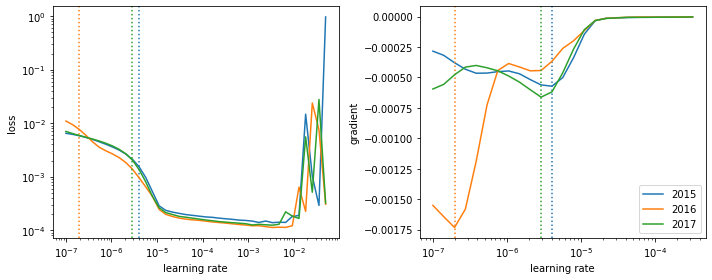

In [28]:
fig = plot(years, 'FluxGraphLSTM', ext = '_0', stop=-15)
fig.savefig(osp.join(fig_dir, 'FluxGraphLSTM_0.png'), bbox_inches='tight', dpi=dpi)

For all three test years, we see a minimum in the loss curve with learning rates between 1e-6 and 1e-5. 
For 2016, the global minimum is between 1e-7 and 1e-6. However, based on visual inspection of the loss curve and the fact that this doesn't occur for the other years,
we conclude that a learning rate of 5e-6 seems to be a good choice for this model in general.

### With 1 graph layers

year 2015: best lr = 2.743999999999999e-07
year 2016: best lr = 1.4757890559999992e-06
year 2017: best lr = 2.743999999999999e-07


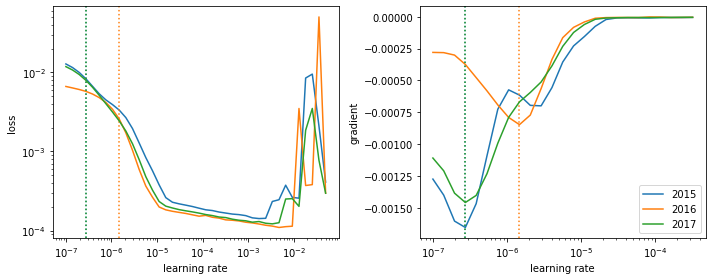

In [29]:
fig = plot(years, 'FluxGraphLSTM', ext = '_1', stop=-15)
fig.savefig(osp.join(fig_dir, 'FluxGraphLSTM_1.png'), bbox_inches='tight', dpi=dpi)

### With 2 graph layers

year 2015: best lr = 2.743999999999999e-07
year 2016: best lr = 3.8415999999999986e-07
year 2017: best lr = 1.9599999999999996e-07


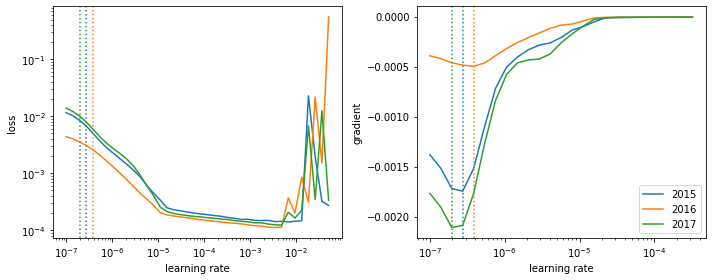

In [30]:
fig = plot(years, 'FluxGraphLSTM', ext = '_2', stop=-15)
fig.savefig(osp.join(fig_dir, 'FluxGraphLSTM_2.png'), bbox_inches='tight', dpi=dpi)

For all three test years, we see a minimum in the loss curve with learning rates between 1e-7 and 1e-6. 
Therefore, we conclude that a learning rate of 5e-7 seems to be a good choice for this model.

## Model: LocalLSTM

year 2015: best lr = 1.4757890559999992e-06
year 2016: best lr = 1.4757890559999992e-06
year 2017: best lr = 1.0541350399999994e-06


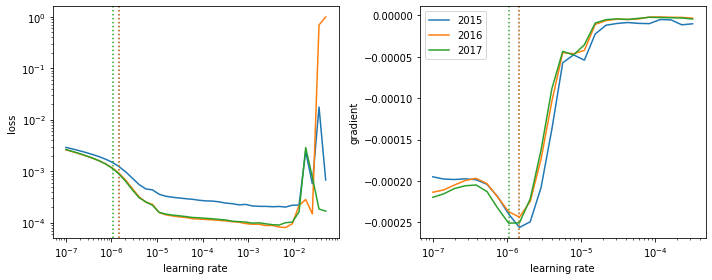

In [31]:
fig = plot(years, 'LocalLSTM', stop=-15)
fig.savefig(osp.join(fig_dir, 'LocalLSTM.png'), bbox_inches='tight', dpi=dpi)

## Model: LocalMLP

### With 3 layers with width 256 

year 2015: best lr = 4.2687885421063616e-05
year 2016: best lr = 3.0491346729331156e-05
year 2017: best lr = 3.0491346729331156e-05


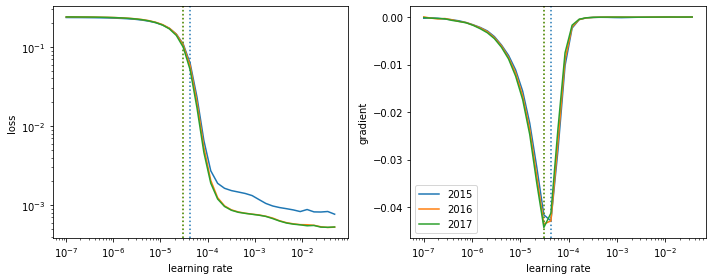

In [32]:
fig = plot(years, 'LocalMLP', stop=-1)
fig.savefig(osp.join(fig_dir, 'LocalMLP.png'), bbox_inches='tight', dpi=dpi)

### With 1 layer with width 64 

year 2015: best lr = 0.00044998795805848297
year 2016: best lr = 0.00044998795805848297
year 2017: best lr = 0.00032141997004177356


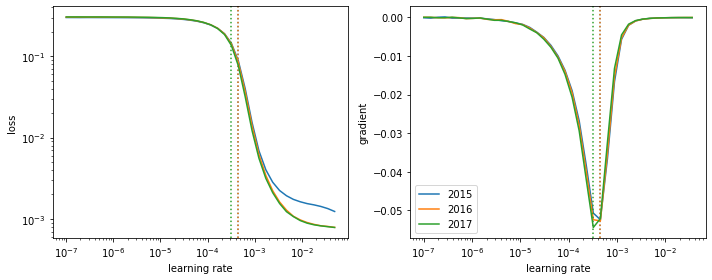

In [33]:
fig = plot(years, 'LocalMLP', stop=-1, ext='_64')
fig.savefig(osp.join(fig_dir, 'LocalMLP_64.png'), bbox_inches='tight', dpi=dpi)

For LocalMLP models with 1-3 layers and 64-256 neurons per layer, learning rates between 1e-5 and 1e-3 seem to be most suitable. We thus use this range in the hyperparameter grid search to find the overall best model setting.